# Исследование результатов А/А/В теста в мобильном приложении по продаже продуктов питания

Стартапу, который продаёт продукты питания необходимо провести проверку результатов А/А/В теста. С помощью него нужно разобраться, как ведут себя пользователи мобильного приложения.

Для экспериментальной группы были изменены шрифты предложения, для двух контрольных групп все оставили кае есть.

## 1. Изучение файла с данными и предобработка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math as mth
from pylab import rcParams
from scipy import stats as st

%config InlineBackend.figure_format = 'retina'

In [ ]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков нет. Для удобства работы сменим названия колонок, приведем их к нижнему регистру и изменим формат даты. Также добавим еще две колонки с датой и временем события.

In [ ]:
data = data.rename(columns={'EventName':'event', 'DeviceIDHash':'id', 'EventTimestamp':'timestamp', 'ExpId':'group'})
data.head()

,event,id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = pd.to_datetime(data['timestamp'].dt.date)
data.head()

,event,id,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [ ]:
data['time'] = data['timestamp'].dt.time
data.head()

,event,id,timestamp,group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   id         244126 non-null  int64         
 2   timestamp  244126 non-null  datetime64[ns]
 3   group      244126 non-null  int64         
 4   date       244126 non-null  datetime64[ns]
 5   time       244126 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


In [ ]:
data[data.duplicated()]

,event,id,timestamp,group,date,time
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30,08:19:44
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31,21:51:39
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01,02:59:37
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01,03:47:46
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01,04:44:01
...,...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247,2019-08-07,19:26:44
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247,2019-08-07,19:26:45
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07,19:27:29
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07,19:27:29


In [ ]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   id         243713 non-null  int64         
 2   timestamp  243713 non-null  datetime64[ns]
 3   group      243713 non-null  int64         
 4   date       243713 non-null  datetime64[ns]
 5   time       243713 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


## 2. Данные о пользователях и событиях датасета

In [ ]:
data['group'].value_counts().sort_values(ascending=False)

248    85582
246    80181
247    77950
Name: group, dtype: int64

In [ ]:
data.groupby('group')['id'].nunique().sort_values(ascending=False)

group
248    2542
247    2520
246    2489
Name: id, dtype: int64

In [ ]:
data['id'].nunique()

7551

События и пользователи поделены на три экспериментальные группы. В группе "248" и пользователей и событий больше, чем в каждой из остальных. Самое малое число пользователей в группе "246", но событий там больше, чем в группе "247". Пользователи корректно размещены по группам, "пересекающихся" пользователей нет.

In [ ]:
data.groupby('event')['id'].count().sort_values(ascending=False)

event
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: id, dtype: int64

In [ ]:
data.groupby('event')['id'].nunique().sort_values(ascending=False)

event
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: id, dtype: int64

Всего у нас 5 видов событий: главный экран, спецпредложение, корзина, окно успешной оплаты и туториал. 

In [ ]:
data.pivot_table(index=['group','event'], values='id', aggfunc='nunique')

id
group event                        
246   CartScreenAppear         1270
      MainScreenAppear         2456
      OffersScreenAppear       1545
      PaymentScreenSuccessful  1202
      Tutorial                  279
247   CartScreenAppear         1240
      MainScreenAppear         2482
      OffersScreenAppear       1530
      PaymentScreenSuccessful  1160
      Tutorial                  286
248   CartScreenAppear         1239
      MainScreenAppear         2501
      OffersScreenAppear       1538
      PaymentScreenSuccessful  1185
      Tutorial                  282

В каждой группе присутствуют все виды событий.

In [ ]:
users = data['id'].unique()
users_246 = data.query('group == 246')['id'].unique()
users_247 = data.query('group == 247')['id'].unique()
users_248 = data.query('group == 248')['id'].unique()
len(users_246), len(users_247), len(users_248), len(users)

(2489, 2520, 2542, 7551)

In [ ]:
data['event'].count()/len(users)

32.27559263673685

In [ ]:
data.query('group == 246')['event'].count()/len(users_246)

32.214142225793495

In [ ]:
data.query('group == 247')['event'].count()/len(users_247)

30.932539682539684

In [ ]:
data.query('group == 248')['event'].count()/len(users_248)

33.66719118804091

В целом у нас 3 группы, в которых неравномерно размещен 7551 пользователь (2489 чел., 2520 чел. и 2542 чел.) Количество событий - 244126, видов событий - 5. В среднем на каждого пользователя приходится 32,3 события. В группе "248" эта цифра самая большая - 33,7 события на пользователя, затем идет группа "246", самая малочисленная, - 32,3 события на пользователя. В группе "247" 31 событие на пользователя.

## 3. Определение корректного временного промежутка для анализа 

In [ ]:
data['date'].min(), data['date'].max()

(Timestamp('2019-07-25 00:00:00'), Timestamp('2019-08-07 00:00:00'))

У нас данные с 25 июля 2019г. по 07 августа 2019г.

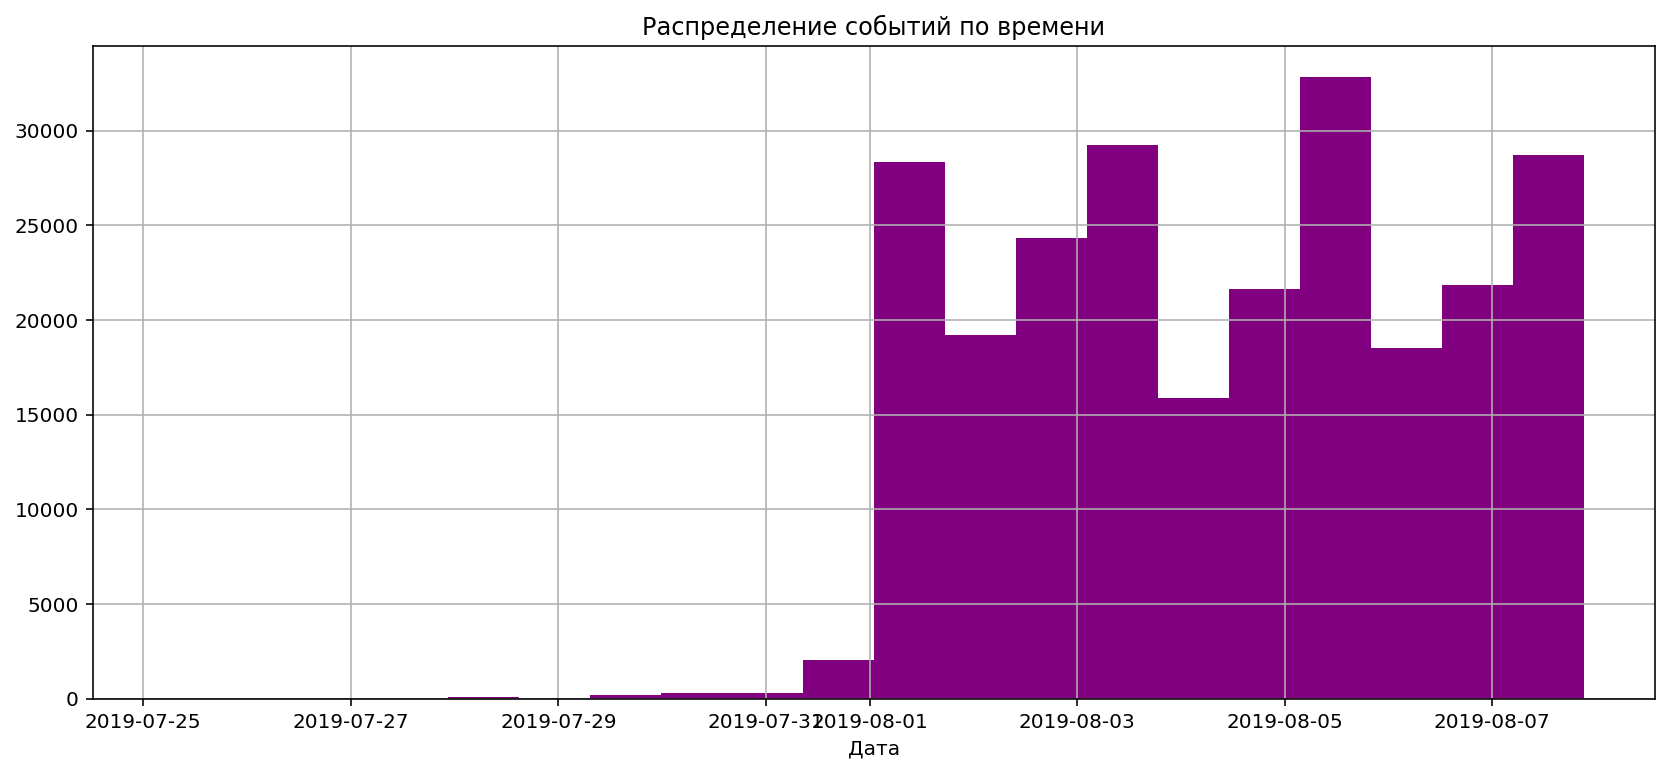

In [ ]:
data['timestamp'].hist(bins=20, figsize=(14,6), color='purple')
plt.title('Распределение событий по времени')
plt.xlabel('Дата');

События распределены по времени очень неравномерно, активность пользователей начинается после 30 июля.

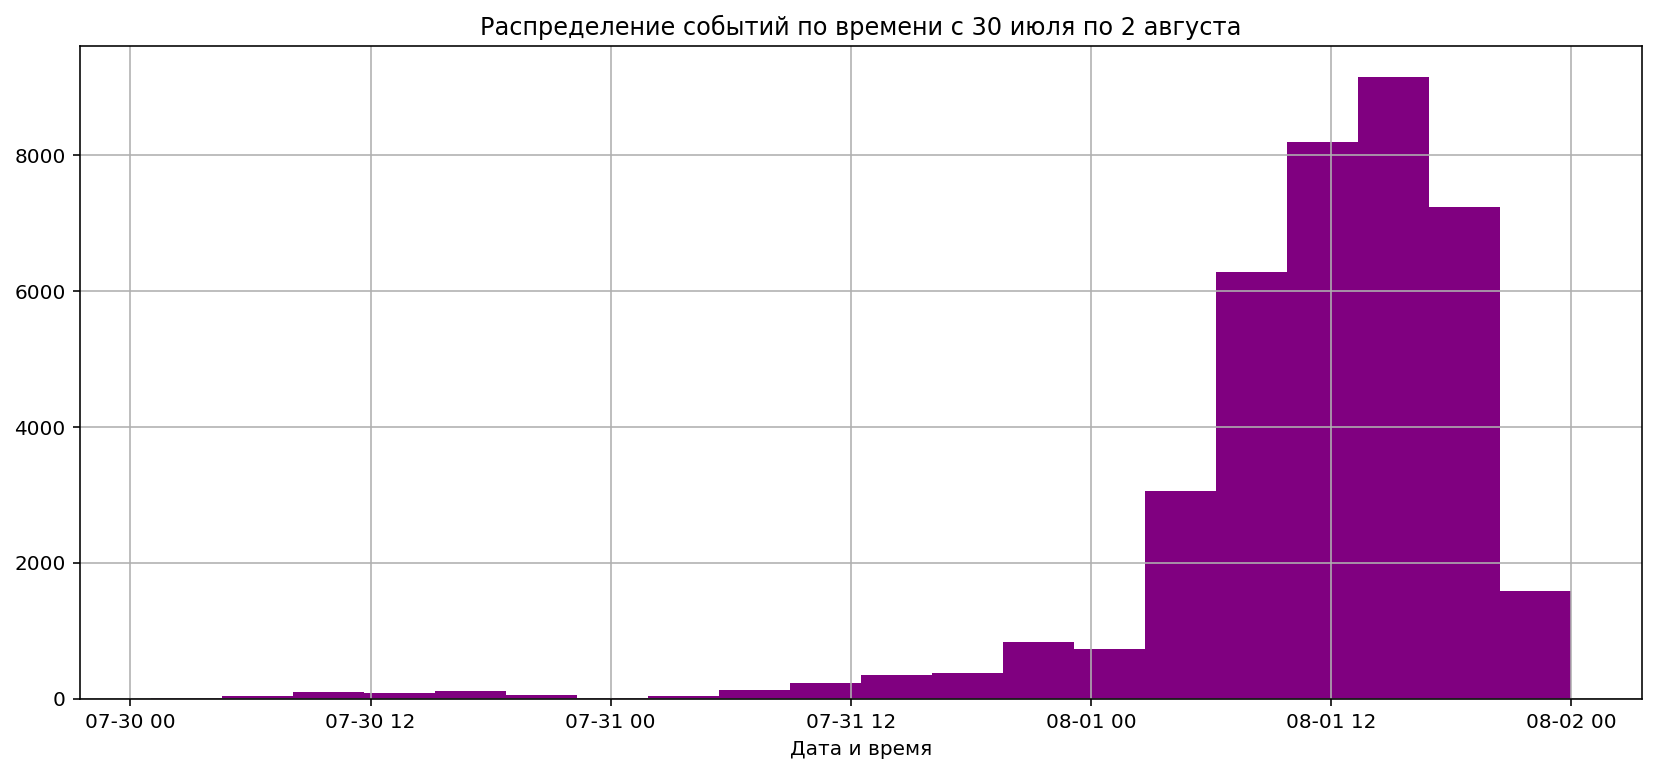

In [ ]:
data.query('timestamp > "2019-07-30" and timestamp < "2019-08-02"')['timestamp'].hist(bins=20, figsize=(14,6), color='purple')
plt.title('Распределение событий по времени с 30 июля по 2 августа')
plt.xlabel('Дата и время');

In [ ]:
data.groupby('date')['event'].count(), data.groupby('date')['id'].nunique()

(date
 2019-07-25        9
 2019-07-26       31
 2019-07-27       55
 2019-07-28      105
 2019-07-29      184
 2019-07-30      412
 2019-07-31     2030
 2019-08-01    36141
 2019-08-02    35554
 2019-08-03    33282
 2019-08-04    32968
 2019-08-05    36058
 2019-08-06    35788
 2019-08-07    31096
 Name: event, dtype: int64,
 date
 2019-07-25       7
 2019-07-26      22
 2019-07-27      39
 2019-07-28      69
 2019-07-29     135
 2019-07-30     296
 2019-07-31     924
 2019-08-01    3703
 2019-08-02    3647
 2019-08-03    3482
 2019-08-04    3527
 2019-08-05    3802
 2019-08-06    3922
 2019-08-07    3651
 Name: id, dtype: int64)

Количество событий и пользователей резко возрастает с 1 августа и остается на том же уровне до конца эксперимента.

In [ ]:
data.groupby(['date','group'])['id'].nunique()

date        group
2019-07-25  246         4
            247         1
            248         2
2019-07-26  246         7
            247         7
            248         8
2019-07-27  246        14
            247        17
            248         8
2019-07-28  246        26
            247        25
            248        18
2019-07-29  246        44
            247        41
            248        50
2019-07-30  246        93
            247        96
            248       107
2019-07-31  246       285
            247       314
            248       325
2019-08-01  246      1191
            247      1282
            248      1230
2019-08-02  246      1197
            247      1221
            248      1229
2019-08-03  246      1140
            247      1176
            248      1166
2019-08-04  246      1170
            247      1169
            248      1188
2019-08-05  246      1269
            247      1263
            248      1270
2019-08-06  246      1270
            247     

Каждый день активность проявляют пользователи из всех трех групп.

In [ ]:
data.groupby(['date','event'])['id'].nunique()

date        event                  
2019-07-25  CartScreenAppear              2
            MainScreenAppear              4
            OffersScreenAppear            1
            PaymentScreenSuccessful       2
2019-07-26  CartScreenAppear              6
                                       ... 
2019-08-07  CartScreenAppear           1434
            MainScreenAppear           3482
            OffersScreenAppear         2062
            PaymentScreenSuccessful    1361
            Tutorial                     69
Name: id, Length: 66, dtype: int64

In [ ]:
data.query('event == "Tutorial"').groupby(['date', 'group'])['id'].nunique()

date        group
2019-07-26  247       1
2019-07-27  246       1
            247       1
2019-07-31  247       3
            248       5
2019-08-01  246      50
            247      58
            248      47
2019-08-02  246      57
            247      43
            248      45
2019-08-03  246      43
            247      51
            248      49
2019-08-04  246      38
            247      40
            248      52
2019-08-05  246      24
            247      50
            248      25
2019-08-06  246      45
            247      31
            248      42
2019-08-07  246      25
            247      19
            248      25
Name: id, dtype: int64

In [ ]:
data1 = data[data['date'] >= "2019-08-01"]
data1.head()

,event,id,timestamp,group,date,time
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59


Для аналитики возьмем период, начиная с 01 августа. В этот отрезок времени мы видим выоску и примерно одинаковую ежедневную активность пользователей.

In [ ]:
data['id'].nunique(), data['event'].count()

(7551, 243713)

In [ ]:
data1['id'].nunique(), data1['event'].count()

(7534, 240887)

In [ ]:
users1 = data1['id'].unique()
users1_246 = data1.query('group == 246')['id'].unique()
users1_247 = data1.query('group == 247')['id'].unique()
users1_248 = data1.query('group == 248')['id'].unique()
len(users1_246), len(users1_247), len(users1_248)

(2484, 2513, 2537)

Эксперимент вошел в полную силу после 1 августа, этот пеирод мы возьмем для анализа. После корректировки временного отрезка мы потеряли 17 пользователей (0,2%) и 2828 событий (1,2%). По-прежнему у нас есть пользователи во всех группах и их количество различно (2484 чел., 2513 чел. и 2537 чел.) 

## 3. Изучение воронки событий

### 3.1. Построение воронки событий по частоте и количеству пользователей

In [ ]:
data1.pivot_table(index='event', values='id', aggfunc=['count','nunique'])

,count,nunique
,id,id
event,,
CartScreenAppear,42303,3734
MainScreenAppear,117328,7419
OffersScreenAppear,46333,4593
PaymentScreenSuccessful,33918,3539
Tutorial,1005,840


In [ ]:
piv_count = data1.pivot_table(index='event', values='id', aggfunc='count').sort_values(by='id',ascending=False)
piv_count

,id
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [ ]:
piv_nun = data1.pivot_table(index='event', values='id', aggfunc='nunique').sort_values(by='id',ascending=False)
piv_nun['%'] = round(piv_nun['id']/data1['id'].nunique()*100,1)
piv_nun

,id,%
event,,
MainScreenAppear,7419,98.5
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.6
PaymentScreenSuccessful,3539,47.0
Tutorial,840,11.1


Самое частое событие - главный экран приложения, он был показан 117431 раз, но его увидели только 98,5% пользователей. Еще 1,5% открыли приложение и увидели главный экран до 00:00 01 августа 2019г. Реже всего пользователи открывают туториал (11,1%).

In [ ]:
piv_group_246 = data1.query('group == 246').pivot_table(index='event', values='id', aggfunc='nunique')
piv_group_246['%'] = round(piv_group_246['id']/data1.query('group == 246')['id'].nunique()*100,1)
piv_group_246.sort_values(by='id',ascending=False)

,id,%
event,,
MainScreenAppear,2450,98.6
OffersScreenAppear,1542,62.1
CartScreenAppear,1266,51.0
PaymentScreenSuccessful,1200,48.3
Tutorial,278,11.2


In [ ]:
piv_group_247 = data1.query('group == 247').pivot_table(index='event', values='id', aggfunc='nunique')
piv_group_247['%'] = round(piv_group_247['id']/data1.query('group == 247')['id'].nunique()*100,1)
piv_group_247.sort_values(by='id',ascending=False)

,id,%
event,,
MainScreenAppear,2476,98.5
OffersScreenAppear,1520,60.5
CartScreenAppear,1238,49.3
PaymentScreenSuccessful,1158,46.1
Tutorial,283,11.3


In [ ]:
piv_group_248 = data1.query('group == 248').pivot_table(index='event', values='id', aggfunc='nunique')
piv_group_248['%'] = round(piv_group_248['id']/data1.query('group == 248')['id'].nunique()*100,1)
piv_group_248.sort_values(by='id',ascending=False)

,id,%
event,,
MainScreenAppear,2493,98.3
OffersScreenAppear,1531,60.3
CartScreenAppear,1230,48.5
PaymentScreenSuccessful,1181,46.6
Tutorial,279,11.0


In [ ]:
for value in data1['group'].unique():
    funnel_group = data1.query('group == @value').pivot_table(index='event', values='id', aggfunc='nunique')
    funnel_group['%'] = round(funnel_group['id']/data1.query('group == @value')['id'].nunique()*100,1)
    print("Группа ", value)
    print(funnel_group.sort_values(by='id',ascending=False))
    print()

Группа  246
                           id     %
event                              
MainScreenAppear         2450  98.6
OffersScreenAppear       1542  62.1
CartScreenAppear         1266  51.0
PaymentScreenSuccessful  1200  48.3
Tutorial                  278  11.2

Группа  247
                           id     %
event                              
MainScreenAppear         2476  98.5
OffersScreenAppear       1520  60.5
CartScreenAppear         1238  49.3
PaymentScreenSuccessful  1158  46.1
Tutorial                  283  11.3

Группа  248
                           id     %
event                              
MainScreenAppear         2493  98.3
OffersScreenAppear       1531  60.3
CartScreenAppear         1230  48.5
PaymentScreenSuccessful  1181  46.6
Tutorial                  279  11.0



Воронка выглядит следующим образом: главный экран приложения --> экран спецпредложения --> корзина --> экран успешной оплаты. Прохождение туториала можно исключить из воронки, это опционально и востребовано только 11% пользователей и не может быть учтено как шаг воронки.

В разбивке воронки по группам мы видим, что пользователи из группы "246" лидируют в относительном порядке по всем видам событий (кроме туториала). В живых цифрах они меньше остальных открывали главный экран приложения, но чаще видели спецпредложение, корзину и экран успешной оплаты.

### 3.2. Порядок и учет событий в воронке

Сформируем новую базу данных без туториала.

In [ ]:
data_new = data1.query('event != "Tutorial"')
data_new.head()

,event,id,timestamp,group,date,time
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59
2831,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01,00:10:15


In [ ]:
data_new.pivot_table(index='event', values='id', aggfunc=['count','nunique'])

,count,nunique
,id,id
event,,
CartScreenAppear,42303,3734
MainScreenAppear,117328,7419
OffersScreenAppear,46333,4593
PaymentScreenSuccessful,33918,3539


In [ ]:
funnel = data_new.pivot_table(index='event', values='id', aggfunc='nunique').sort_values(by='id',ascending=False)
funnel

,id
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [ ]:
for value in data_new['group'].unique():
    funnel_group = data_new.query('group == @value').pivot_table(index='event', values='id', aggfunc='nunique')
    funnel_group['%'] = round(funnel_group['id']/data_new.query('group == @value')['id'].nunique()*100,1)
    print("Группа ", value)
    print(funnel_group.sort_values(by='id',ascending=False))
    print()

Группа  246
                           id     %
event                              
MainScreenAppear         2450  98.7
OffersScreenAppear       1542  62.1
CartScreenAppear         1266  51.0
PaymentScreenSuccessful  1200  48.3

Группа  247
                           id     %
event                              
MainScreenAppear         2476  98.6
OffersScreenAppear       1520  60.5
CartScreenAppear         1238  49.3
PaymentScreenSuccessful  1158  46.1

Группа  248
                           id     %
event                              
MainScreenAppear         2493  98.3
OffersScreenAppear       1531  60.4
CartScreenAppear         1230  48.5
PaymentScreenSuccessful  1181  46.6



Теперь у нас в воронке всего 4 шага.

### 3.3. Конверсия пользователей по шагам воронки.


По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [ ]:
funnel_step_perc = data_new.pivot_table(index='event', values='id', aggfunc='nunique').sort_values(by='id',ascending=False)
funnel_step_perc['%'] = round(funnel_step_perc.loc['MainScreenAppear','id']/funnel_step_perc.loc['MainScreenAppear','id']*100,1)
funnel_step_perc.loc['OffersScreenAppear','%'] = round(funnel_step_perc.loc['OffersScreenAppear','id']/funnel_step_perc.loc['MainScreenAppear','id']*100,1)
funnel_step_perc.loc['CartScreenAppear','%'] = round(funnel_step_perc.loc['CartScreenAppear','id']/funnel_step_perc.loc['OffersScreenAppear','id']*100,1)
funnel_step_perc.loc['PaymentScreenSuccessful','%'] = round(funnel_step_perc.loc['PaymentScreenSuccessful','id']/funnel_step_perc.loc['CartScreenAppear','id']*100,1)
funnel_step_perc

,id,%
event,,
MainScreenAppear,7419,100.0
OffersScreenAppear,4593,61.9
CartScreenAppear,3734,81.3
PaymentScreenSuccessful,3539,94.8


В целом по трем группам больше всего пользователей (38,1%) у нас "отваливается" до второго шага - экрана спецпредложения. Из тех, кто увидел спецпредложение до корзины доходят 81,3% и только 5,2% пользователей, открывших корзину, не совершат покупку.

In [ ]:
funnel_full = data_new.pivot_table(index='event', values='id', aggfunc='nunique').sort_values(by='id',ascending=False)
funnel_full['%'] = round(funnel_full['id']/funnel_full.loc['MainScreenAppear','id']*100,1)
funnel_full

,id,%
event,,
MainScreenAppear,7419,100.0
OffersScreenAppear,4593,61.9
CartScreenAppear,3734,50.3
PaymentScreenSuccessful,3539,47.7


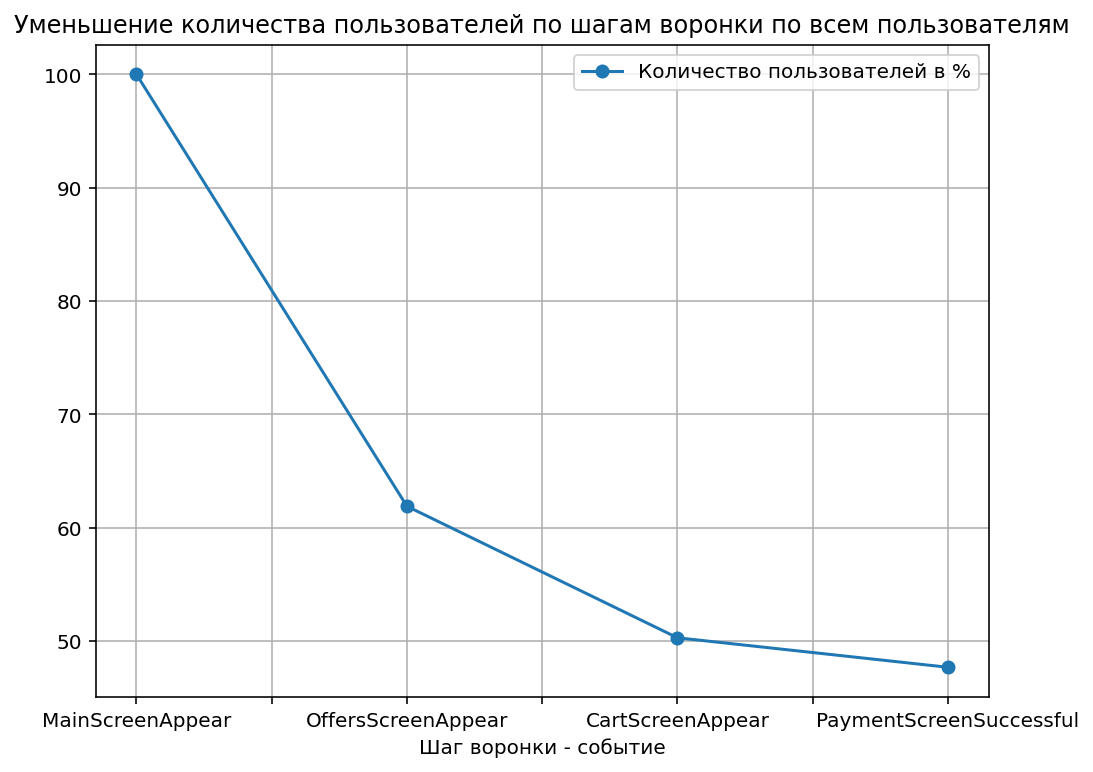

In [ ]:
funnel_full.sort_values(by='id',ascending=False).plot(y='%', figsize=(8,6), style='-o', legend=False, grid=True)
plt.title('Уменьшение количества пользователей по шагам воронки по всем пользователям')
plt.xlabel('Шаг воронки - событие')
plt.legend(['Количество пользователей в %']);

Если рассмотреть воронку в относительных цифрах к начальному количеству пользователей, мы видим, что 52,3% открывших приложение не совершают покупку, 38,1% не открывают экран спецпредложения. Непонятно, показывается спецпредложение всем пользователям или приходит только некоторым из них. Но, судя по цифрам, это все-таки обязательный шаг воронки.

In [ ]:
for value in data_new['group'].unique():
    funnel_by_step = data_new.query('group == @value').pivot_table(index='event', values='id', aggfunc='nunique')
    funnel_by_step['%'] = round(funnel_by_step.loc['MainScreenAppear','id']/funnel_by_step.loc['MainScreenAppear','id']*100,1)
    funnel_by_step.loc['OffersScreenAppear','%'] = round(funnel_by_step.loc['OffersScreenAppear','id']/funnel_by_step.loc['MainScreenAppear','id']*100,1)
    funnel_by_step.loc['CartScreenAppear','%'] = round(funnel_by_step.loc['CartScreenAppear','id']/funnel_by_step.loc['OffersScreenAppear','id']*100,1)
    funnel_by_step.loc['PaymentScreenSuccessful','%'] = round(funnel_by_step.loc['PaymentScreenSuccessful','id']/funnel_by_step.loc['CartScreenAppear','id']*100,1)
    print("Группа ", value)
    print(funnel_by_step.sort_values(by='id',ascending=False))
    print()

Группа  246
                           id      %
event                               
MainScreenAppear         2450  100.0
OffersScreenAppear       1542   62.9
CartScreenAppear         1266   82.1
PaymentScreenSuccessful  1200   94.8

Группа  247
                           id      %
event                               
MainScreenAppear         2476  100.0
OffersScreenAppear       1520   61.4
CartScreenAppear         1238   81.4
PaymentScreenSuccessful  1158   93.5

Группа  248
                           id      %
event                               
MainScreenAppear         2493  100.0
OffersScreenAppear       1531   61.4
CartScreenAppear         1230   80.3
PaymentScreenSuccessful  1181   96.0



Группа "248" показала самую лучшую конверсию в шаге от корзины до оплаты и самую плохую в шаге от спецпердложения до корзины. В группе "246" пользователи лучше шли от главного экрана до спецпредложения, а потом и до корзины. но от корзины до оплаты показали конверсию хуже, чем группа "248". Больше всего пользователей уходит на первом шаге, открывая только главный экран приложения.

In [ ]:
for value in data_new['group'].unique():
    funnel_full = data_new.query('group == @value').pivot_table(index='event', values='id', aggfunc='nunique')
    funnel_full['%'] = round(funnel_full['id']/funnel_full.loc['MainScreenAppear','id']*100,1)
    print("Группа ", value)
    print(funnel_full.sort_values(by='id',ascending=False))
    print()

Группа  246
                           id      %
event                               
MainScreenAppear         2450  100.0
OffersScreenAppear       1542   62.9
CartScreenAppear         1266   51.7
PaymentScreenSuccessful  1200   49.0

Группа  247
                           id      %
event                               
MainScreenAppear         2476  100.0
OffersScreenAppear       1520   61.4
CartScreenAppear         1238   50.0
PaymentScreenSuccessful  1158   46.8

Группа  248
                           id      %
event                               
MainScreenAppear         2493  100.0
OffersScreenAppear       1531   61.4
CartScreenAppear         1230   49.3
PaymentScreenSuccessful  1181   47.4



In [ ]:
funnel_full = data_new.query('group == 246 or group == 247').pivot_table(index='event', values='id', aggfunc='nunique')
funnel_full['%'] = round(funnel_full['id']/funnel_full.loc['MainScreenAppear','id']*100,1)
funnel_full.sort_values(by='id',ascending=False)

,id,%
event,,
MainScreenAppear,4926,100.0
OffersScreenAppear,3062,62.2
CartScreenAppear,2504,50.8
PaymentScreenSuccessful,2358,47.9


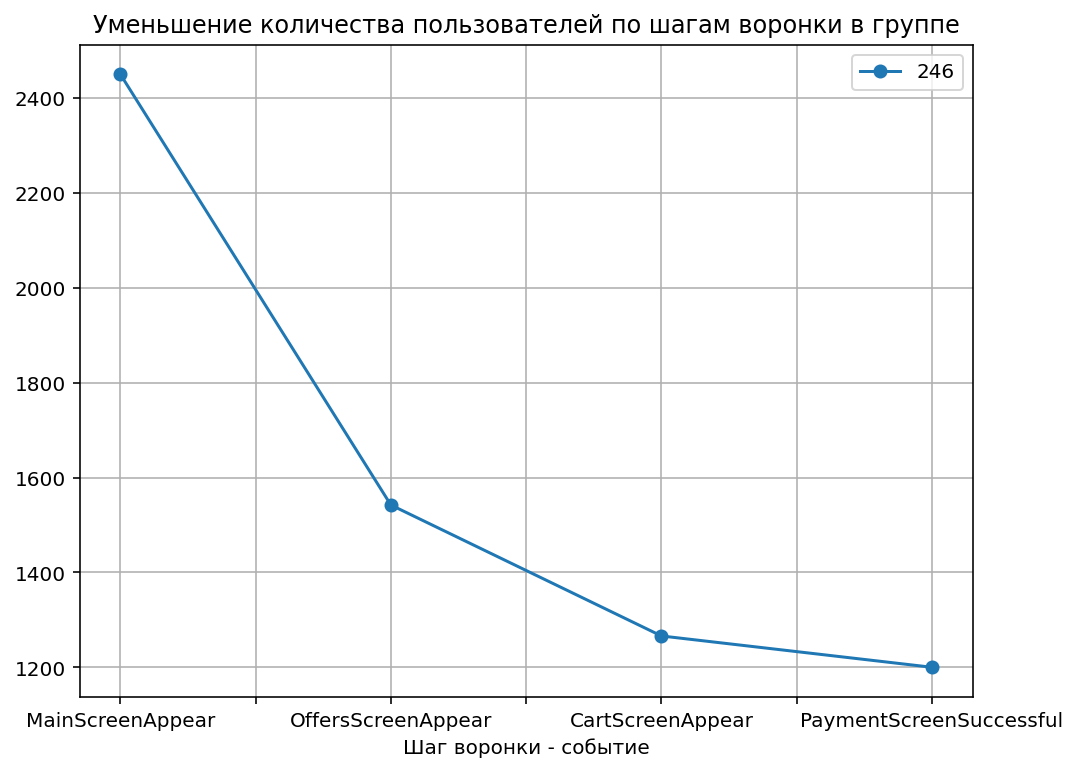

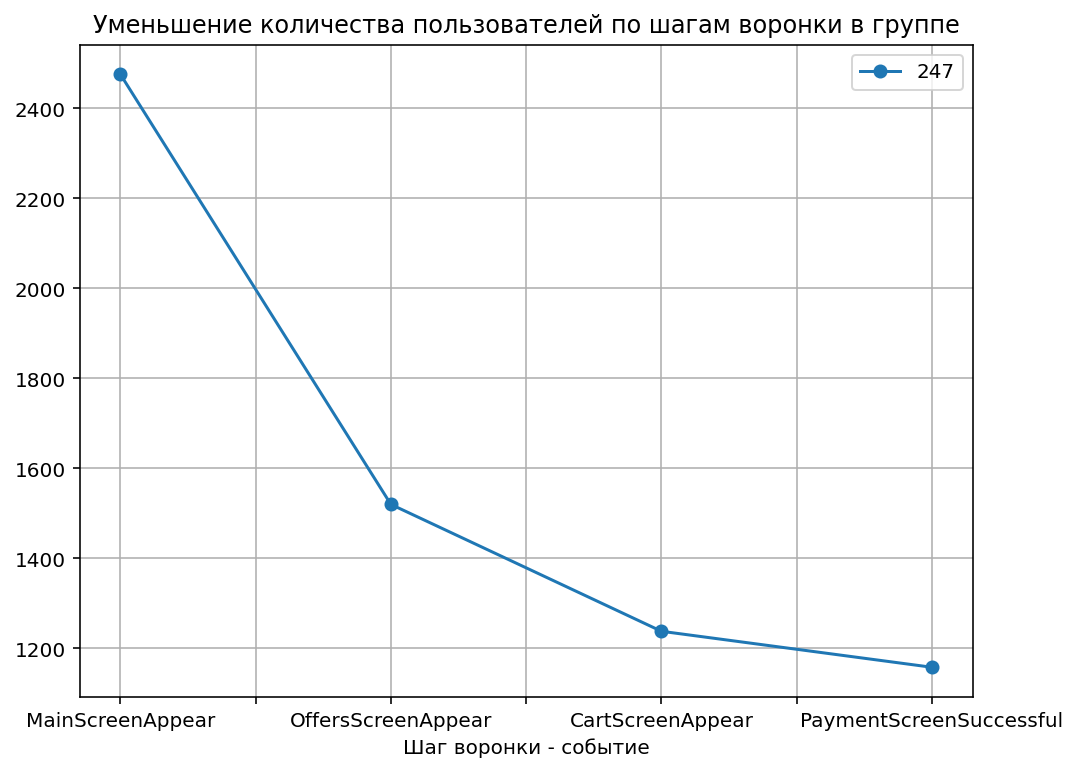

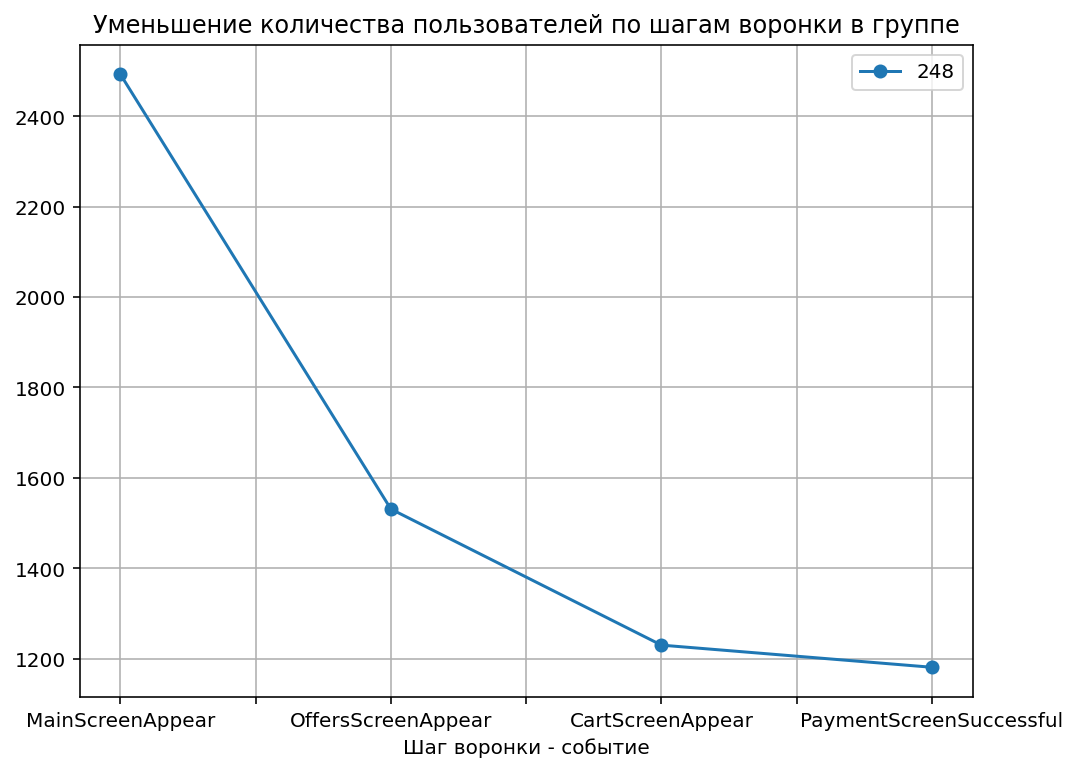

In [ ]:
for value in data_new['group'].unique():
    funnel_by_step = data_new.query('group == @value').pivot_table(index='event', values='id', aggfunc='nunique')
    funnel_by_step['%'] = round(funnel_by_step.loc['MainScreenAppear','id']/funnel_by_step.loc['MainScreenAppear','id']*100,1)
    funnel_by_step.loc['OffersScreenAppear','%'] = round(funnel_by_step.loc['OffersScreenAppear','id']/funnel_by_step.loc['MainScreenAppear','id']*100,1)
    funnel_by_step.loc['CartScreenAppear','%'] = round(funnel_by_step.loc['CartScreenAppear','id']/funnel_by_step.loc['OffersScreenAppear','id']*100,1)
    funnel_by_step.loc['PaymentScreenSuccessful','%'] = round(funnel_by_step.loc['PaymentScreenSuccessful','id']/funnel_by_step.loc['CartScreenAppear','id']*100,1)
    funnel_by_step.sort_values(by='id',ascending=False).plot(y='id', figsize=(8,6), style='-o', grid=True)
    plt.legend([value])
    plt.xlabel('Шаг воронки - событие')
    plt.title('Уменьшение количества пользователей по шагам воронки в группе');

В экспериментальной группе на втором шаге воронки мы видим результат такой же (61,4%), как у котрольной группы "247" и он ниже, чем у контрольной группы "246". На третьем шаге - корзина - группа "248" показывает самый плохой результат из всех (49,3%). До оплаты из экспериментальной группы добрались только 47,4% пользователей, это второй результат. Группа "246" выдала лучшие показатели - 49%.

После объединения двух контрольных групп в одну и сравнения с группой "248" можно однозначно заключить, что у экспериментальной группы результаты хуже. До оплаты добралось на 0,5% меньше пользователей.

## 4. Проверка статистических гипотез

### 4.1. Гипотеза о разнице между выборками контрольных групп.

In [ ]:
data_new.groupby('group')['id'].nunique()

group
246    2483
247    2512
248    2535
Name: id, dtype: int64

In [ ]:
users_events_per_group = data_new.pivot_table(index='event', columns='group', values='id', aggfunc='nunique')
users_events_per_group

group,246,247,248
event,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181


In [ ]:
users_per_group = data_new.pivot_table(index='group', values='id', aggfunc='nunique')
users_per_group

,id
group,
246,2483
247,2512
248,2535


Пользователи на группы разделены неравномерно, экспериментальная группа - самая большая. Проверим гипотезу о равенстве долей. Для этого напишем функцию для проверки.

Нулевая гипотеза: между долями нет значимой разницы.
Альтернативная гипотеза: между долями есть значимая разница.

In [ ]:
def statistical_significance(successes1, successes2, trials1, trials2):

    alpha = 0.05    
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

statistical_significance(users_events_per_group.loc['MainScreenAppear', 246],
                 users_events_per_group.loc['MainScreenAppear', 247],
                 users_per_group.loc[246],
                 users_per_group.loc[247])     

p-значение:  [0.75267034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
statistical_significance(users_events_per_group.loc['OffersScreenAppear',246],
                 users_events_per_group.loc['OffersScreenAppear',247],
                 users_per_group.loc[246],
                 users_per_group.loc[247])         

p-значение:  [0.24786097]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
statistical_significance(users_events_per_group.loc['CartScreenAppear',246],
                 users_events_per_group.loc['CartScreenAppear',247],
                 users_per_group.loc[246],
                 users_per_group.loc[247])  

p-значение:  [0.22867644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
statistical_significance(users_events_per_group.loc['PaymentScreenSuccessful',246],
                 users_events_per_group.loc['PaymentScreenSuccessful',247],
                 users_per_group.loc[246],
                 users_per_group.loc[247])  

p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На всех 4-х шагах воронки разницы между долями в группах "246" и "247" нет.

### 4.2. Гипотеза о равенстве долей между экспериментальной и контрольными группами. 

In [ ]:
for value in data_new['group'].unique():
    funnel_group = data_new.query('group == @value').pivot_table(index='event', values='id', aggfunc='nunique')
    funnel_group['%'] = round(funnel_group['id']/data_new.query('group == @value')['id'].nunique()*100,1)
    print("Группа ", value)
    print(funnel_group.sort_values(by='id',ascending=False))
    print()

Группа  246
                           id     %
event                              
MainScreenAppear         2450  98.7
OffersScreenAppear       1542  62.1
CartScreenAppear         1266  51.0
PaymentScreenSuccessful  1200  48.3

Группа  247
                           id     %
event                              
MainScreenAppear         2476  98.6
OffersScreenAppear       1520  60.5
CartScreenAppear         1238  49.3
PaymentScreenSuccessful  1158  46.1

Группа  248
                           id     %
event                              
MainScreenAppear         2493  98.3
OffersScreenAppear       1531  60.4
CartScreenAppear         1230  48.5
PaymentScreenSuccessful  1181  46.6



Используя прежнюю функцию, проверим гипотезу о равенстве долей между экспериментальной и каждой из контрольных групп в отдельности.

Нулевая гипотеза: между долями нет значимой разницы. Альтернативная гипотеза: между долями есть значимая разница.

In [ ]:
def check_event(users_events_per_group, users_per_group, event, exp1, exp2):
    frac1 = users_events_per_group.loc[event, exp1] / users_per_group.loc[exp1]
    frac2 = users_events_per_group.loc[event, exp2] / users_per_group.loc[exp2]
    statistical_significance(users_events_per_group.loc[event, exp1], 
              users_events_per_group.loc[event, exp2], 
              users_per_group.loc[exp1], users_per_group.loc[exp2])

for event in users_events_per_group.index:
    check_event(users_events_per_group, users_per_group,
                          event, 246, 248)

p-значение:  [0.08067368]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.33871141]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.21442477]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.21693034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
for event in users_events_per_group.index:
    check_event(users_events_per_group, users_per_group,
                          event, 247, 248)

p-значение:  [0.58782846]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.51949644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.93337513]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.72757187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ни на одном шаге гипотеза не была отвергнута, нет оснований считать доли разными.

### 4.3. Гипотеза о равенстве долей между экспериментальной и объединенной контрольной группой

Объединим контрольные группы в одну и проверим гипотезу о равенстве долей между объединенной контрольной группой и экспериментальной.

Нулевая гипотеза: между долями нет значимой разницы. Альтернативная гипотеза: между долями есть значимая разница.

In [ ]:
users_events_per_group_1 = data_new.pivot_table(index='event', columns='group', values='id', aggfunc='nunique')
users_events_per_group_1[246247] = users_events_per_group_1[246] + users_events_per_group_1[247]
users_events_per_group_1

group,246,247,248,246247
event,,,,
CartScreenAppear,1266,1238,1230,2504
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
PaymentScreenSuccessful,1200,1158,1181,2358


In [ ]:
users_per_group_1 = data_new.pivot_table(index='group', values='id', aggfunc='nunique')
a = users_per_group_1.loc[246] + users_per_group_1.loc[247]
row = pd.Series(data=a, name=246247) 
users_per_group_1 = users_per_group_1.append(row, ignore_index=False)
users_per_group_1

,id
group,
246,2483
247,2512
248,2535
246247,4995


In [ ]:
def check_event(users_events_per_group_1, users_per_group_1, event, exp1, exp2):
    frac1 = users_events_per_group_1.loc[event, exp1] / users_per_group_1.loc[exp1]
    frac2 = users_events_per_group_1.loc[event, exp2] / users_per_group_1.loc[exp2]
    statistical_significance(users_events_per_group_1.loc[event, exp1], 
              users_events_per_group_1.loc[event, exp2], 
              users_per_group_1.loc[exp1], users_per_group_1.loc[exp2]) 

for event in users_events_per_group_1.index:
    check_event(users_events_per_group_1, users_per_group_1,
                          event, 246247, 248)

p-значение:  [0.18683559]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.34866843]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.44582745]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.61079187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ни на одном шаге гипотеза не была отвергнута, нет оснований считать доли разными.

<div style="border:solid green 2px; padding: 20px"> 
    
**Комментарий ревьюера**

**#ок**

Гипотезы проверены правильно. Т.е. получается, что все такие ни одна группа не хуже и не лучше другой
</div>

Не смотря на то, что группы у нас были не равны по составу, проверка показала, что разбиение на группы проведено корректно и результаты теста можно также признать корректными. Проверка проведена при уровне значимости 5%, увеличивать или уменьшеть его я не вижу смысла.

In [ ]:
def statistical_significance_with_bonferroni(successes1, successes2, trials1, trials2, alpha):
    
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    bonferroni_alpha = alpha/16  # произведено 16 сравнений
        
    print(event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )  

In [ ]:
def check_event_with_bonferroni(users_events_per_group_1, users_per_group_1, event, exp1, exp2):
    frac1 = users_events_per_group_1.loc[event, exp1] / users_per_group_1.loc[exp1]
    frac2 = users_events_per_group_1.loc[event, exp2] / users_per_group_1.loc[exp2]
    statistical_significance_with_bonferroni(users_events_per_group_1.loc[event, exp1], 
              users_events_per_group_1.loc[event, exp2], 
              users_per_group_1.loc[exp1], users_per_group_1.loc[exp2], 0.05) 

In [ ]:
for event in users_events_per_group_1.index:
    check_event_with_bonferroni(users_events_per_group_1, users_per_group_1,
                          event, 246, 247)

CartScreenAppear
p-значение:  [0.22867644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
MainScreenAppear
p-значение:  [0.75267034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear
p-значение:  [0.24786097]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful
p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
for event in users_events_per_group_1.index:
    check_event_with_bonferroni(users_events_per_group_1, users_per_group_1,
                          event, 246, 248)

CartScreenAppear
p-значение:  [0.08067368]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
MainScreenAppear
p-значение:  [0.33871141]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear
p-значение:  [0.21442477]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful
p-значение:  [0.21693034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
for event in users_events_per_group_1.index:
    check_event_with_bonferroni(users_events_per_group_1, users_per_group_1,
                          event, 247, 248)

CartScreenAppear
p-значение:  [0.58782846]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
MainScreenAppear
p-значение:  [0.51949644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear
p-значение:  [0.93337513]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful
p-значение:  [0.72757187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
for event in users_events_per_group_1.index:
    check_event_with_bonferroni(users_events_per_group_1, users_per_group_1,
                          event, 246247, 248)

CartScreenAppear
p-значение:  [0.18683559]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
MainScreenAppear
p-значение:  [0.34866843]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear
p-значение:  [0.44582745]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful
p-значение:  [0.61079187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


## Выводы и рекомендации

По результатам эксперимента можно заключить, что изменение шрифтов не принесло увеличения конверсии пользователей, а, наоборот, показало худшие результаты по сравнению с объединенной контрольной группой. До оплаты дошло 47,4% пользователей в группе с новыми шрифтами, в объединенной контрольной группе результат - 47,9%. 

При сравнении с каждой контрольной группой в отдельности экспериментальная группа показала второй результат после группы "246", в которой до оплаты дошло 49% пользователей. 

В экспериментальной группе "248" пользователей больше (2542 чел.), чем в каждой из контрольных (2489 чел. и 2520 чел.) Эксперимент проводился с 25 июля 2019г. по 07 августа 2019г., но данные для аналитики учитывают период с 01 августа, из-за этого пришлось отказаться от данных по 0,2% пользователей. 

Воронка конверсии выглядит следующим образом: главный экран приложения --> экран спецпредложения --> корзина --> экран успешной оплаты. Прохождение туториала можно исключить из воронки, это опционально и востребовано только 11% пользователей.

Шаг, на которм теряется самое большое число пользователей - это самое начало, открытие главного экрана. На следующий шаг - открытие спецпредложения переходит только 61,9% пользователей, до корзины добирается 49,7%.

Лидер по конверсии - контрольная группа "246", она же самая малочисленная. Эти пользователи обошли и вторую контрольную и экспериментальную группу. Основное различие между ними - относительная часть пользователей, открывших экран спецпредложения. В группе "246" этот процент самый высокий - 62,9%, в двух других группах - 61,4%. Судя по всему, это решающий момент. Из тех, кто увидел спецпредложение до корзины в среднем доходят 81,3%, из них 94,8% совершат покупку. Чем больше пользователей увидят спецпредложение, тем больше покупок будет сделано. Возможно, спецпредложение нужно показывать прямо при открытии главного экрана, а не отдельным шагом. 

Изменение шрифта показало положительный результат в одном шаге - при переходе от корзины к оплате. У экспериментальной группы здесь однозначное лидерство - конверсия 96% (у других групп 94,8% и 93,5%). Возможно, стоит внести какие-то изменения в оформление корзины.